In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def derivative(f, x, h=0.001):
    return (f(x + h) - f(x - h)) / (2*h)

In [23]:
class Object:
    def y_coords(self, x):
        pass

    def normal_line_slope(self, y):
        pass

    def collides_with(self, ray_x):
        pass

In [44]:
class Circle(Object):
    def __init__(self, x0, y0, radius):
        self.x0 = x0
        self.y0 = y0
        self.r = radius

    def y_coords(self, x):
        return np.sqrt(self.r**2 - (x - self.x0)**2) + self.y0

    def normal_line_slope(self, x):
        return -1 / derivative(self.y_coords, x)

    def collides_with(self, ray_x):
        if self.x0 - r <= ray_x <= self.x0 + r:
            return self.y_coords(ray_x)

        return None

In [32]:
class Line(Object):
    def __init__(self, x0, x1, y0, y1):
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1

    def y_coords(self, x):
        try:
            return len(x) * [self.y0]
        except TypeError:
            return self.y0

    def normal_line_slope(self, x):
        return np.inf if self.y0 - self.y1 == 0 else -1 / derivative(self.y_coords(x), x)

    def collides_with(self, ray_x):
        if self.x0 <= ray_x <= self.x1:
            return self.y_coords(ray_x)

        return None

In [7]:
def point_slope(x_point, y_point, x, slope):
    return slope * (x - x_point) + y_point

In [8]:
def critical_angle(refr_idx_1, refr_idx_2):
    return np.arcsin(refr_idx_2 / refr_idx_1)

In [9]:
def snell_refraction(refr_idx_1, refr_idx_2, angle_1):
    return np.arcsin(np.sin(angle_1) * refr_idx_1 / refr_idx_2)

In [19]:
def trace_ray(ray_position, ray_end, objects, refr_idx_air, refr_idx_glass):
    slope = 0
    x_slope_change = ray_position[0]
    y_slope_change = ray_position[1]

    ray_points = [[ray_position[0], ray_position[1]]]

    n_passed_objects = 0

    for i in np.arange(ray_position[0], ray_end, 0.01):
        current_ray_position = [i, point_slope(x_slope_change, y_slope_change, i, slope)]
        for obj in objects:
            if obj.collides_with(i, current_ray_position[1], 0.01):
                norm_slope = obj.normal_line_slope(current_ray_position[1])

                norm_angle = np.arctan(norm_slope)

                refr_idx_1 = refr_idx_air if n_passed_objects % 2 == 0 else refr_idx_glass
                refr_idx_2 = refr_idx_glass if n_passed_objects % 2 == 0 else refr_idx_air

                # print(norm_angle)

                if norm_angle > critical_angle(refr_idx_1, refr_idx_2):
                    ray_angle_norm = -norm_angle
                else:
                    ray_angle_norm = snell_refraction(refr_idx_1, refr_idx_2, norm_angle)
                print(current_ray_position[1], i, ray_angle_norm, norm_angle, slope, n_passed_objects)
                ray_angle = ray_angle_norm + norm_angle
                ray_slope = np.tan(ray_angle)
                slope = ray_slope
                x_slope_change = current_ray_position[0]
                y_slope_change = current_ray_position[1]
                n_passed_objects += 1

        ray_points.append([current_ray_position[0], current_ray_position[1]])

    return np.array(ray_points)

In [20]:
critical_angle(1.52, 1)

0.7180199093984887

In [58]:
r = 6

circ_1 = Circle(0, 0, r)
line_1 = Line(-r, r, 0, 0)

objects = (line_1, circ_1)

In [152]:
rays = []

for i in np.arange(-4, 4.25, 0.5):
    print('ray', i)
    rays.append(np.swapaxes(trace_ray([-3, i], 2*r, objects, 1, 1.52), 0, 1))

ray -4.0
ray -3.5
ray -3.0
ray -2.5


/tmp/ipykernel_48979/430948632.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.r**2 - (y - self.y0)**2) + self.x0


ray -2.0
ray -1.5
ray -1.0
-1.0 -6.394884621840902e-14 nan nan 0 0
ray -0.5
ray 0.0


/tmp/ipykernel_48979/448008599.py:2: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(refr_idx_2 / refr_idx_1)
/tmp/ipykernel_48979/430948632.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return -1 / derivative(self.x_coords, y)


0.0 0.9999999999999147 0.0 0.0 0 0
ray 0.5
ray 1.0
1.0 -6.394884621840902e-14 nan nan 0 0
1.0 -6.394884621840902e-14 nan nan nan 1
ray 1.5
ray 2.0
2.0 0.9999999999999147 0.0 0.0 0 0
ray 2.5
ray 3.0
3.0 -6.394884621840902e-14 nan nan 0 0
3.0 -6.394884621840902e-14 nan nan nan 1
ray 3.5
ray 4.0
4.0 0.9999999999999147 0.0 0.0 0 0


In [16]:
rays = []

for i in np.arange(-2.5, 2.55, 0.5):
    rays.append(np.swapaxes(trace_ray([-3, i], 2*r, objects, 1, 1.52), 0, 1))

-2.5 -6.394884621840902e-14 0.0 0.0 0 0
-2.5 0.009999999999935838 0.0 0.0 0.0 1
-2.5 5.44999999999982 0.27767745595381066 0.42977543900771575 0.0 2
-2.4914489054887468 5.45999999999982 0.6830569286327557 0.4282082461006762 0.8551094511253594 3
-2.4712413728713845 5.4699999999998195 0.2744000211080013 0.4245091722838794 2.020753261736262 4
-2.462837118748144 5.479999999999819 0.6737471875189434 0.42297256083933754 0.840425412324067 5
-2.0 -6.394884621840902e-14 0.0 0.0 0 0
-2.0 0.009999999999935838 0.0 0.0 0.0 1
-2.0 5.649999999999816 0.22109515302244134 0.3398369149783067 0.0 2
-1.9937175127339595 5.659999999999815 0.5294689903941272 0.33872653534442376 0.6282487266040652 3
-1.9819075690697365 5.669999999999815 0.21906230162574772 0.33664039557281455 1.1809943664223281 4
-1.5 -6.394884621840902e-14 0.0 0.0 0 0
-1.5 0.009999999999935838 0.0 0.0 0.0 1
-1.5 5.799999999999812 0.16522440761909096 0.2526802589676038 0.0 2
-1.495559383074898 5.809999999999812 0.38858041917991426 0.25191595938

/tmp/ipykernel_5494/448008599.py:2: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(refr_idx_2 / refr_idx_1)
/tmp/ipykernel_5494/430948632.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.r**2 - (y - self.y0)**2) + self.x0
/tmp/ipykernel_5494/430948632.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return -1 / derivative(self.x_coords, y)


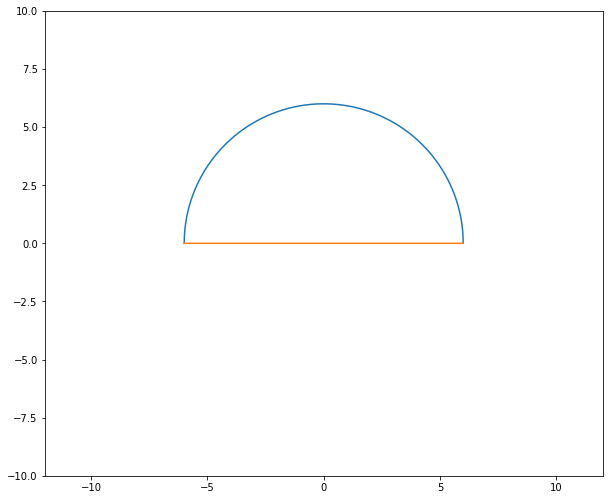

In [59]:
fig, ax = plt.subplots()

x_vals = np.arange(-r, r+0.01, 0.01)
ax.plot(x_vals, circ_1.y_coords(x_vals))
ax.plot(x_vals, line_1.y_coords(x_vals))

# for ray in rays:
#     ax.plot(ray[0], ray[1], color='red')

plt.xlim(-r*2, r*2)
plt.ylim(-10, 10)
ax.set_aspect(1)
fig.set_size_inches(10, 10)
plt.show()